# Machine Learning Guide for Petroleum Professionals: Part 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import math, copy

## Import data

In [2]:
data = pd.read_csv('Stochastic_1D_por_perm_demo.csv')
data_top_bottom = pd.concat([data.head(5), data.tail(5)])
table_style = [{'selector': 'th', 'props': [('background-color', '#4287f5'), ('color', 'white'), ('font-size', '14px'), ('border', '1px solid black')]},
               {'selector': 'td', 'props': [('border', '1px solid black'), ('font-size', '14px'), ('text-align', 'center')]}]
styled_table = data_top_bottom.style.set_table_styles(table_style)
styled_table

,Unnamed: 0,Porosity,Permeability
0,0,13.746408,193.721529
1,1,9.608479,105.718666
2,2,11.664361,138.539297
3,3,8.375338,93.719985
4,4,13.183358,169.738824
100,100,8.042614,84.564471
101,101,19.887759,453.228801
102,102,11.118544,128.606149
103,103,16.051620,265.341789
104,104,17.762477,337.335817


## Dropping Unnamed: 0 column and checking null

In [3]:
data = data.drop(data.columns[0], axis=1)
null_values = data.isnull().sum()

# Print the results
print(null_values)

Porosity        0
Permeability    0
dtype: int64


## Defining X as Porosity and Y as Permeability

In [4]:
X = data["Porosity"]
Y = data["Permeability"]
X = X.values.reshape(-1,1)
Y = Y.values.reshape(-1,1)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

X shape: (105, 1)
Y shape: (105, 1)


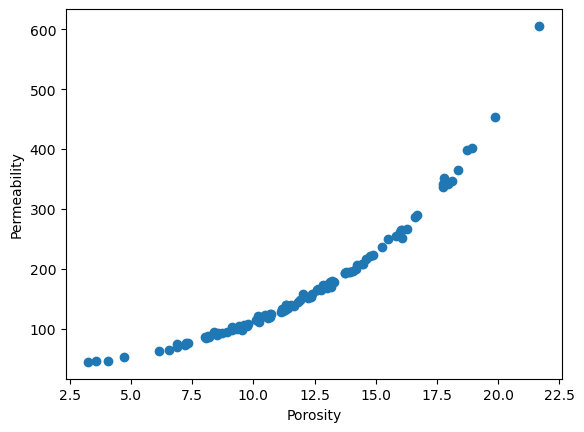

In [5]:
# Porosity vs Permeability plot
plt.scatter(X,Y)
plt.xlabel("Porosity")
plt.ylabel("Permeability")
plt.show()

## Scaling data

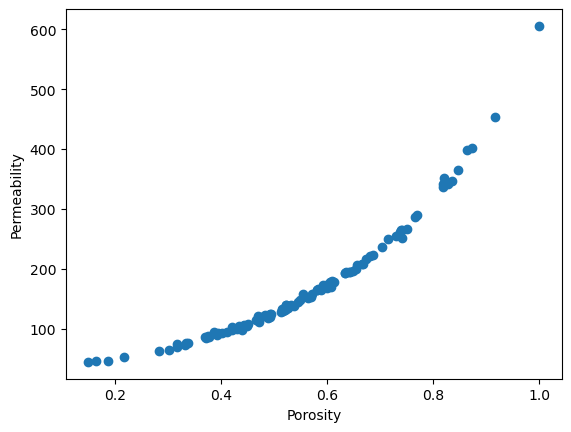

In [6]:
X = X/np.max(X)
plt.scatter(X,Y)
plt.xlabel("Porosity")
plt.ylabel("Permeability")
plt.show()

## Splitting Data into training and testing sets

In [7]:
def split_data(X, Y):
    total_samples = X.shape[0]
    train_samples = int(0.8 * total_samples)
    test_samples = int(0.20 * total_samples)

    X_train = X[:train_samples].T
    Y_train = Y[:train_samples].T

    X_test = X[train_samples:train_samples+test_samples].T
    Y_test = Y[train_samples:train_samples+test_samples].T
    print(f"X_train shape: {X_train.shape}")
    print(f"Y_train shape: {Y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Y_test shape: {Y_test.shape}")

    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = split_data(X, Y)

X_train shape: (1, 84)
Y_train shape: (1, 84)
X_test shape: (1, 21)
Y_test shape: (1, 21)


## Defining several functions for our Neural Network

In [8]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1])*np.sqrt(2/layers_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters

def linear_forward(A, W, b):
    Z = np.dot(W,A) + b 
    cache = (A, W, b)
    return Z, cache

def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache

def linear_activation_forward(A_prev, W, b):
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = relu(Z)    
    cache = (linear_cache, activation_cache)
    return A, cache

def compute_cost(AL, Y, parameters):
    m = Y.shape[1]
    cost = np.sum((AL-Y)**2)/(2*m)
    total_cost = np.squeeze(cost)
    return total_cost

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ, axis = 1, keepdims = True)/m
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache):
    linear_cache, activation_cache = cache
    dZ = relu_backward(dA,activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l + 1)]
    return parameters

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)])
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)])
    caches.append(cache)
    return AL, caches

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    dAL = AL-Y 
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache)
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads['dA' + str(l + 1)], current_cache)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

def L_layer_model(X, Y, layers_dims, learning_rate = 0.075, num_iterations = 1000, print_cost=False):
    np.random.seed(100)
    costs = []                         # keep track of cost
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y, parameters)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 500 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    error = (np.abs(AL - Y))/(np.abs(Y))
    avg_error = np.mean(error)
    percent_error = avg_error*100
    print(f"error is {percent_error}%")
    accuracy = (1 - avg_error)*100
    print(f"accuracy is {accuracy}%")
    plt.scatter(X,Y, marker='o', c='r', label="Actual Value", s = 50)
    plt.scatter(X,AL, marker='o',label="Predicted Value", s = 50);  plt.xlabel("Porosity"); plt.ylabel("Permeability"); plt.legend(); plt.show()
    # Print final values of W and b
    #print(parameters.keys())
    for i in range(1, len(layers_dims)):
        print(f"Final value of W{i}: {parameters['W' + str(i)]}")
        print(f"Final value of b{i}: {parameters['b' + str(i)]}")
        print(f"Shape of W{i}: {parameters['W' + str(i)].shape}")
        print(f"Shape of b{i}: {parameters['b' + str(i)].shape}")

    return parameters, costs

## Model 1

Cost after iteration 0: 16933.196200643408
Cost after iteration 500: 3727.3643324041063
Cost after iteration 999: 3726.7646592543924
error is 45.08919837760168%
accuracy is 54.91080162239832%


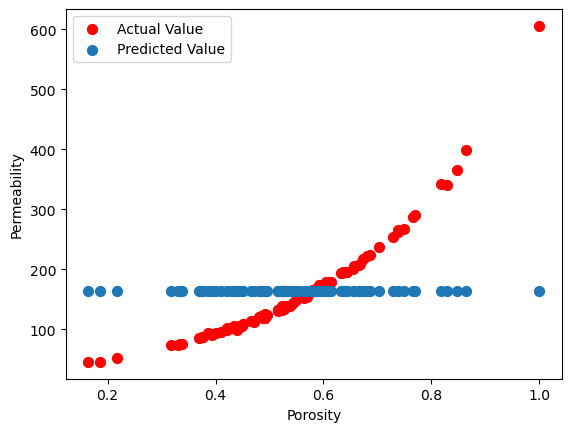

Final value of W1: [[-2.47454206]
 [ 0.23814976]
 [ 0.89192974]]
Final value of b1: [[ 0.        ]
 [-3.44671447]
 [-4.90551003]]
Shape of W1: (3, 1)
Shape of b1: (3, 1)
Final value of W2: [[-0.20611316 -2.96130696 -3.16318484]]
Final value of b2: [[163.17946618]]
Shape of W2: (1, 3)
Shape of b2: (1, 1)


In [9]:
layers_dims = [X_train.shape[0],3,Y_train.shape[0]]
parameters, costs = L_layer_model(X_train, Y_train, layers_dims,learning_rate=0.01, num_iterations = 1000, print_cost = True)

## Model 2

Cost after iteration 0: 16929.06510675614
Cost after iteration 500: 17041.707957664556
Cost after iteration 999: 17041.707957664556
error is 100.0%
accuracy is 0.0%


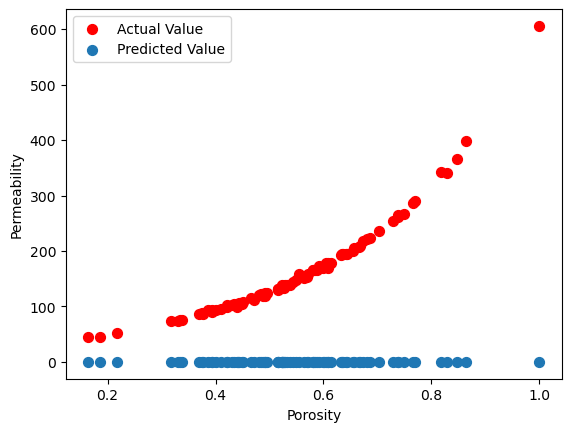

Final value of W1: [[-2.47454206e+00]
 [-1.02389243e+03]
 [-4.18611550e+03]]
Final value of b1: [[    0.        ]
 [-1844.0159454 ]
 [-7538.40946979]]
Shape of W1: (3, 1)
Shape of b1: (3, 1)
Final value of W2: [[-2.06113161e-01 -1.34649200e+02 -5.21468675e+02]
 [ 1.80592444e-01 -8.73686721e-01 -1.54722698e-01]
 [ 2.08207807e-01 -1.79792126e+03 -6.92606881e+03]
 [-4.76503363e-01 -2.10486850e+03 -8.11234718e+03]
 [-8.52513416e-02 -3.74580342e+02 -1.44044309e+03]]
Final value of b2: [[ -30.30994099]
 [   0.        ]
 [-393.40896317]
 [-460.51909364]
 [ -81.59971854]]
Shape of W2: (5, 3)
Shape of b2: (5, 1)
Final value of W3: [[-7.07854414e+01 -7.07286561e-01 -4.78144642e+03 -6.87368924e+03
  -2.68299422e+03]]
Final value of b3: [[-34.06122341]]
Shape of W3: (1, 5)
Shape of b3: (1, 1)


In [10]:
layers_dims = [X_train.shape[0],3,5,Y_train.shape[0]]
parameters, costs = L_layer_model(X_train, Y_train, layers_dims,learning_rate=0.01, num_iterations = 1000, print_cost = True)

## Model 3

Cost after iteration 0: 16929.06510675614
Cost after iteration 500: 574.310738024947
Cost after iteration 999: 310.2689927004175
error is 14.629905656378828%
accuracy is 85.37009434362118%


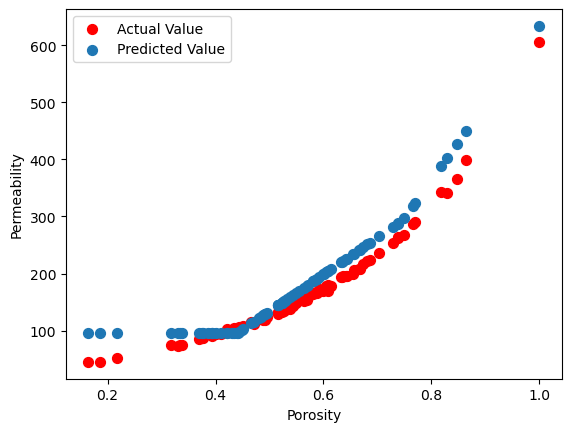

Final value of W1: [[-2.47454206]
 [10.41428582]
 [19.81522835]]
Final value of b1: [[ 0.        ]
 [-8.20979373]
 [-9.40582391]]
Shape of W1: (3, 1)
Shape of b1: (3, 1)
Final value of W2: [[-0.20611316  1.51040446  0.42196502]
 [ 0.18059244 -0.87368672 -0.1547227 ]
 [ 0.20820781  4.37275271  1.9742807 ]
 [-0.47650336  6.68563088  2.60017446]
 [-0.08525134  0.73020362  0.59635113]]
Final value of b2: [[0.98414623]
 [0.        ]
 [6.89642697]
 [8.67246452]
 [1.75212082]]
Shape of W2: (5, 3)
Shape of b2: (5, 1)
Final value of W3: [[ 0.8923328  -0.70728656  4.44960234  5.8748297   1.16380339]]
Final value of b3: [[3.90693732]]
Shape of W3: (1, 5)
Shape of b3: (1, 1)


In [11]:
layers_dims = [X_train.shape[0],3,5,Y_train.shape[0]]
parameters, costs = L_layer_model(X_train, Y_train, layers_dims,learning_rate=0.001, num_iterations = 1000, print_cost = True)

## Model 4

Cost after iteration 0: 16929.06510675614
Cost after iteration 500: 393.7864228013171
Cost after iteration 1000: 387.0248759229164
Cost after iteration 1500: 312.2441757443713
Cost after iteration 2000: 256.09124863438745
Cost after iteration 2500: 185.25175915231043
Cost after iteration 3000: 119.91183820631238
Cost after iteration 3500: 77.47682721564131
Cost after iteration 4000: 56.439032705062175
Cost after iteration 4500: 44.850763633288544
Cost after iteration 4999: 39.85832239105506
error is 4.698060407505137%
accuracy is 95.30193959249486%


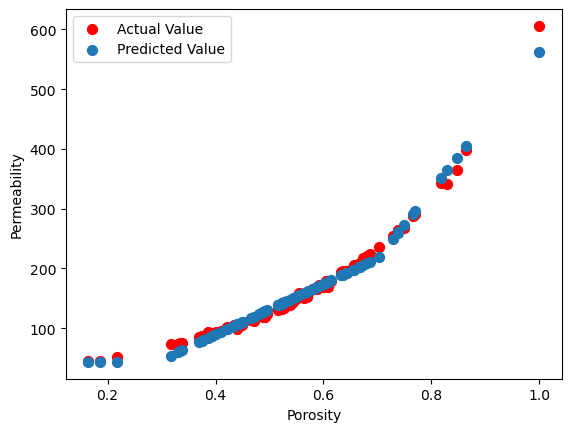

Final value of W1: [[-2.47454206]
 [ 7.22431891]
 [ 6.0457422 ]]
Final value of b1: [[ 0.        ]
 [-5.06627427]
 [-1.7601708 ]]
Shape of W1: (3, 1)
Shape of b1: (3, 1)
Final value of W2: [[-0.20611316  1.9498052   0.73465258]
 [ 0.18059244 -0.87368672 -0.1547227 ]
 [ 0.20820781  4.58611463  3.71926007]
 [-0.47650336  7.28016909  4.57075006]
 [-0.08525134  1.08960878  1.71194751]]
Final value of b2: [[-0.09457517]
 [ 0.        ]
 [ 2.37408851]
 [ 3.02320659]
 [-0.03537772]]
Shape of W2: (5, 3)
Shape of b2: (5, 1)
Final value of W3: [[ 1.90327198 -0.70728656  6.42003872  9.12114893  1.80828358]]
Final value of b3: [[0.894646]]
Shape of W3: (1, 5)
Shape of b3: (1, 1)


In [12]:
layers_dims = [X_train.shape[0],3,5,Y_train.shape[0]]
parameters, costs = L_layer_model(X_train, Y_train, layers_dims,learning_rate=0.0001, num_iterations = 5000, print_cost = True)

## Testing our Model

In [13]:
# Defining test_model
def test_model(X_test, Y_test, parameters):
    AL_test, _ = L_model_forward(X_test, parameters)
    cost = compute_cost(AL_test, Y_test, parameters)
    error = (np.abs(AL_test - Y_test))/(np.abs(Y_test))
    avg_error = np.mean(error)
    percent_error = avg_error*100
    print(f"error is {percent_error:.2f}%")
    accuracy = (1 - avg_error)*100
    print(f"accuracy is {accuracy:.2f}%")
    print("Test cost: " + str(cost))
    
    # Create a dataframe to display actual and predicted values
    df = pd.DataFrame({"Actual Permeability": Y_test.squeeze(), "Predicted Permeability": AL_test.squeeze()})
    data_top_bottom = pd.concat([df.head(5), df.tail(5)])
    table_style = [{'selector': 'th', 'props': [('background-color', '#4287f5'), ('color', 'white'), ('font-size', '14px'), ('border', '1px solid black')]},
               {'selector': 'td', 'props': [('border', '1px solid black'), ('font-size', '14px'), ('text-align', 'center')]}]
    styled_table = data_top_bottom.style.set_table_styles(table_style)
    display(styled_table)
    
    # Plot the actual and predicted values as a scatter plot
    plt.scatter(X_test,Y_test, marker='o', c='r', label="Actual values of permeability", s = 50)
    plt.scatter(X_test,AL_test, marker='o',label="Predicted values of permeability", s = 50)
    plt.xlabel("Porosity")
    plt.ylabel("Permeability")
    plt.legend()
    plt.show()
    
    return AL_test

error is 6.89%
accuracy is 93.11%
Test cost: 67.49472488600681


,Actual Permeability,Predicted Permeability
0,65.227602,48.423159
1,98.809947,102.649599
2,173.684221,173.418657
3,251.375148,263.172400
4,120.779829,119.351362
16,84.564471,77.245457
17,453.228801,466.938151
18,128.606149,137.328746
19,265.341789,262.251597
20,337.335817,353.538548


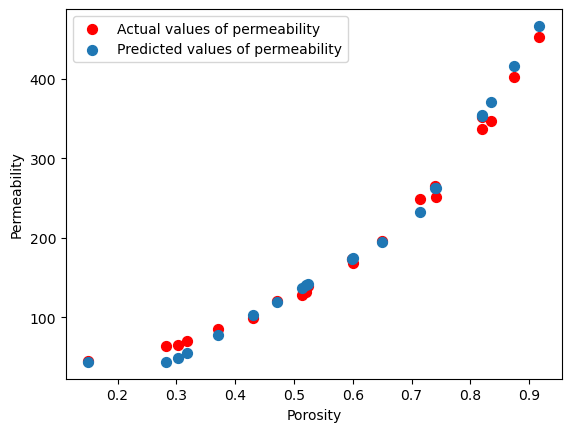

In [14]:
AL_test = test_model (X_test, Y_test, parameters)